In [0]:
from numpy import expand_dims
from numpy import ones
from numpy import zeros
from numpy.random import randn
from numpy.random import randint
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense,Reshape
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Conv2DTranspose
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Input
from numpy import vstack
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm

In [0]:
# loading Data

# Load MNIST data
(X_train, y_train), (X_test, y_test) = load_data()
X_train = (X_train.astype(np.float32) - 127.5)/127.5
X_train = X_train.reshape(60000, 784)
print('X_train shape:', X_train.shape)
print(X_train.shape, 'train samples')
print(X_test.shape, 'test samples')


X_train shape: (60000, 784)
(60000, 784) train samples
(10000, 28, 28) test samples


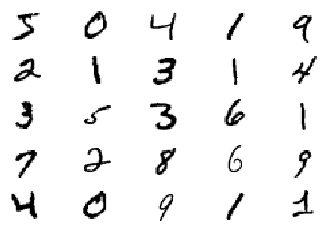

In [0]:
# plot images from the training dataset
(trainX, trainy), (testX, testy) = load_data()

for i in range(25):
	# define subplot
	plt.subplot(5, 5, 1 + i)
	# turn off axis
	plt.axis('off')
	# plot raw pixel data
	plt.imshow(trainX[i], cmap='gray_r')
plt.show()

In [0]:
# defining  optimzer 
adam = Adam(lr=0.0002, beta_1=0.5)
randomDim = 10

In [0]:
# defining discriminator model
discriminator = Sequential()
discriminator.add(Dense(512, input_dim=784))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(128))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=adam)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
# defining generator model

generator = Sequential()
generator.add(Dense(128, input_dim=randomDim))
generator.add(LeakyReLU(0.2))
generator.add(Dense(256))
generator.add(LeakyReLU(0.2))
generator.add(Dense(512))
generator.add(LeakyReLU(0.2))
generator.add(Dense(784, activation='tanh'))
generator.compile(loss='binary_crossentropy', optimizer=adam)

In [0]:
# Combined network
discriminator.trainable = False
ganInput = Input(shape=(randomDim,))
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(inputs=ganInput, outputs=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=adam)

In [0]:
dLosses = []
gLosses = []

# Plot the loss from each batch
def plotLoss(epoch):
    plt.figure(figsize=(10, 8))
    plt.plot(dLosses, label='Discriminitive loss')
    plt.plot(gLosses, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('/content/Images_NL/gan_loss_epoch_%d.png' % epoch)

# Create a wall of generated MNIST images
def plotGeneratedImages(epoch, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, randomDim])
    generatedImages = generator.predict(noise)
    generatedImages = generatedImages.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generatedImages[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('/content/Images_NL/gan_generated_image_epoch_%d.png' % epoch)


In [0]:
# training a model

def train(epochs=1, batchSize=128):
    batchCount = X_train.shape[0] / batchSize
    print('Epochs:', epochs)
    print('Batch size:', batchSize)
    print('Batches per epoch:', batchCount)
    print('randomDim: ', randomDim)

    for e in range(1, epochs+1):
        print('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in tqdm(range(int(batchCount))):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            imageBatch = X_train[np.random.randint(0, X_train.shape[0], size=batchSize)]

            # Generate fake MNIST images
            generatedImages = generator.predict(noise)
            # print np.shape(imageBatch), np.shape(generatedImages)
            X = np.concatenate([imageBatch, generatedImages])

            # Labels for generated and real data
            yDis = np.zeros(2*batchSize)
            # One-sided label smoothing
            yDis[:batchSize] = 0.9

            # Train discriminator
            discriminator.trainable = True
            dloss = discriminator.train_on_batch(X, yDis)
           

            # Train generator
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            yGen = np.ones(batchSize)
            discriminator.trainable = False
            gloss = gan.train_on_batch(noise, yGen)
           

        # Store loss of most recent batch from this epoch
        dLosses.append(dloss)
        gLosses.append(gloss)
        if e == 1 or e % 10 == 0:
            plotGeneratedImages(e)

    # Plot losses from every epoch
    plotLoss(e)

  0%|          | 0/468 [00:00<?, ?it/s]

Epochs: 50
Batch size: 128
Batches per epoch: 468.75
randomDim:  10
--------------- Epoch 1 ---------------


  1%|▏         | 6/468 [00:00<00:07, 59.96it/s]

--------------- Epoch 2 ---------------


  1%|▏         | 7/468 [00:00<00:07, 65.37it/s]

--------------- Epoch 3 ---------------


  2%|▏         | 8/468 [00:00<00:06, 75.88it/s]

--------------- Epoch 4 ---------------


  1%|▏         | 7/468 [00:00<00:07, 61.50it/s]

--------------- Epoch 5 ---------------


  1%|▏         | 7/468 [00:00<00:07, 61.75it/s]

--------------- Epoch 6 ---------------


  1%|▏         | 7/468 [00:00<00:07, 64.28it/s]

--------------- Epoch 7 ---------------


  1%|▏         | 7/468 [00:00<00:07, 59.85it/s]

--------------- Epoch 8 ---------------


  1%|▏         | 7/468 [00:00<00:07, 64.32it/s]

--------------- Epoch 9 ---------------


  2%|▏         | 8/468 [00:00<00:06, 71.77it/s]

--------------- Epoch 10 ---------------


  1%|▏         | 7/468 [00:00<00:06, 68.44it/s]

--------------- Epoch 11 ---------------


  1%|▏         | 7/468 [00:00<00:06, 68.03it/s]

--------------- Epoch 12 ---------------


  1%|▏         | 7/468 [00:00<00:06, 66.94it/s]

--------------- Epoch 13 ---------------


  2%|▏         | 8/468 [00:00<00:06, 71.21it/s]

--------------- Epoch 14 ---------------


  2%|▏         | 8/468 [00:00<00:06, 68.53it/s]

--------------- Epoch 15 ---------------


  1%|▏         | 7/468 [00:00<00:06, 68.06it/s]

--------------- Epoch 16 ---------------


  2%|▏         | 8/468 [00:00<00:05, 77.10it/s]

--------------- Epoch 17 ---------------


  1%|▏         | 7/468 [00:00<00:06, 67.68it/s]

--------------- Epoch 18 ---------------


  1%|▏         | 7/468 [00:00<00:06, 68.90it/s]

--------------- Epoch 19 ---------------


  2%|▏         | 8/468 [00:00<00:06, 72.99it/s]

--------------- Epoch 20 ---------------


  1%|▏         | 6/468 [00:00<00:08, 56.46it/s]

--------------- Epoch 21 ---------------


  2%|▏         | 8/468 [00:00<00:06, 74.23it/s]

--------------- Epoch 22 ---------------


  1%|▏         | 7/468 [00:00<00:06, 67.98it/s]

--------------- Epoch 23 ---------------


  1%|▏         | 6/468 [00:00<00:07, 59.27it/s]

--------------- Epoch 24 ---------------


  2%|▏         | 8/468 [00:00<00:06, 76.31it/s]

--------------- Epoch 25 ---------------


  2%|▏         | 8/468 [00:00<00:06, 76.27it/s]

--------------- Epoch 26 ---------------


  2%|▏         | 8/468 [00:00<00:06, 72.87it/s]

--------------- Epoch 27 ---------------


  2%|▏         | 8/468 [00:00<00:05, 78.85it/s]

--------------- Epoch 28 ---------------


  1%|▏         | 7/468 [00:00<00:07, 62.11it/s]

--------------- Epoch 29 ---------------


  1%|▏         | 7/468 [00:00<00:07, 62.93it/s]

--------------- Epoch 30 ---------------


  1%|▏         | 6/468 [00:00<00:07, 57.99it/s]

--------------- Epoch 31 ---------------


  2%|▏         | 8/468 [00:00<00:06, 73.95it/s]

--------------- Epoch 32 ---------------


  1%|▏         | 7/468 [00:00<00:07, 63.62it/s]

--------------- Epoch 33 ---------------


  2%|▏         | 8/468 [00:00<00:06, 74.13it/s]

--------------- Epoch 34 ---------------


  1%|▏         | 7/468 [00:00<00:06, 67.04it/s]

--------------- Epoch 35 ---------------


  2%|▏         | 8/468 [00:00<00:06, 72.19it/s]

--------------- Epoch 36 ---------------


  1%|▏         | 7/468 [00:00<00:06, 68.65it/s]

--------------- Epoch 37 ---------------


  1%|▏         | 6/468 [00:00<00:08, 57.15it/s]

--------------- Epoch 38 ---------------


  1%|▏         | 7/468 [00:00<00:07, 65.18it/s]

--------------- Epoch 39 ---------------


  1%|▏         | 6/468 [00:00<00:08, 57.40it/s]

--------------- Epoch 40 ---------------


  1%|▏         | 7/468 [00:00<00:07, 65.26it/s]

--------------- Epoch 41 ---------------


  1%|▏         | 7/468 [00:00<00:06, 68.26it/s]

--------------- Epoch 42 ---------------


  1%|▏         | 7/468 [00:00<00:07, 62.61it/s]

--------------- Epoch 43 ---------------


  2%|▏         | 8/468 [00:00<00:06, 70.87it/s]

--------------- Epoch 44 ---------------


  1%|▏         | 6/468 [00:00<00:08, 55.82it/s]

--------------- Epoch 45 ---------------


  2%|▏         | 8/468 [00:00<00:06, 72.68it/s]

--------------- Epoch 46 ---------------


  1%|▏         | 7/468 [00:00<00:07, 64.28it/s]

--------------- Epoch 47 ---------------


  1%|▏         | 6/468 [00:00<00:08, 55.74it/s]

--------------- Epoch 48 ---------------


  2%|▏         | 8/468 [00:00<00:06, 73.89it/s]

--------------- Epoch 49 ---------------


  1%|▏         | 7/468 [00:00<00:07, 62.78it/s]

--------------- Epoch 50 ---------------


100%|██████████| 468/468 [00:07<00:00, 63.85it/s]


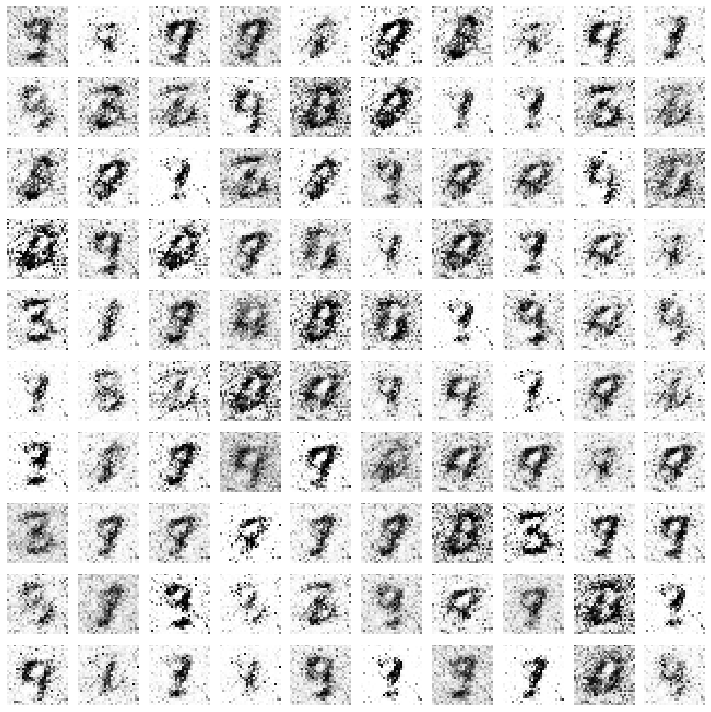

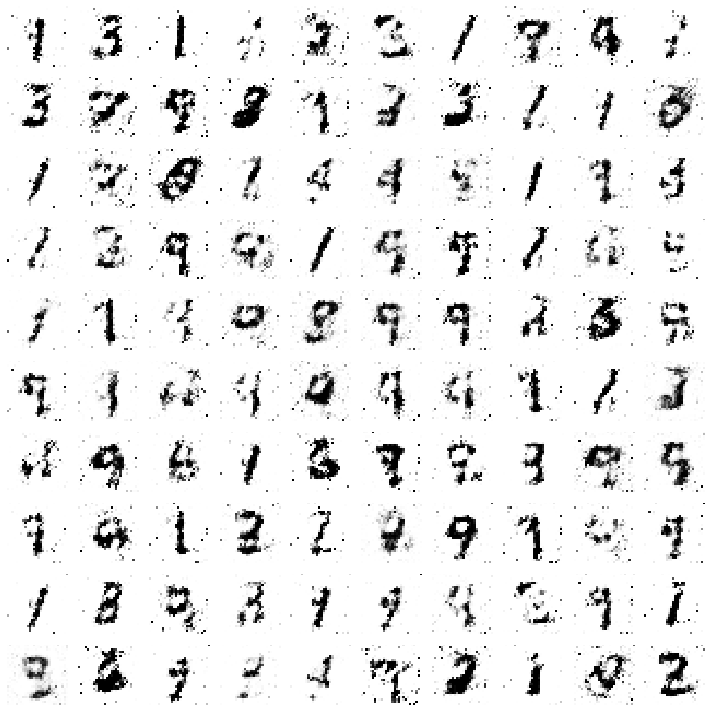

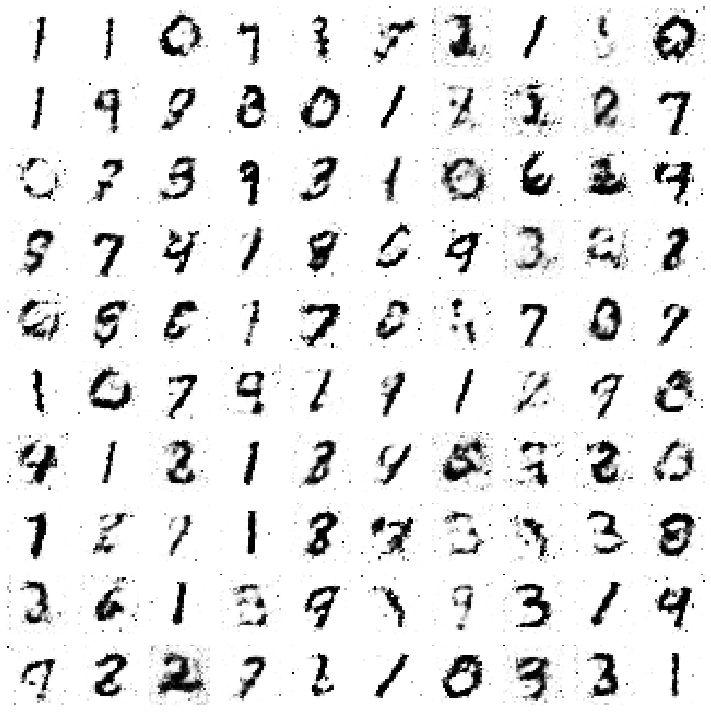

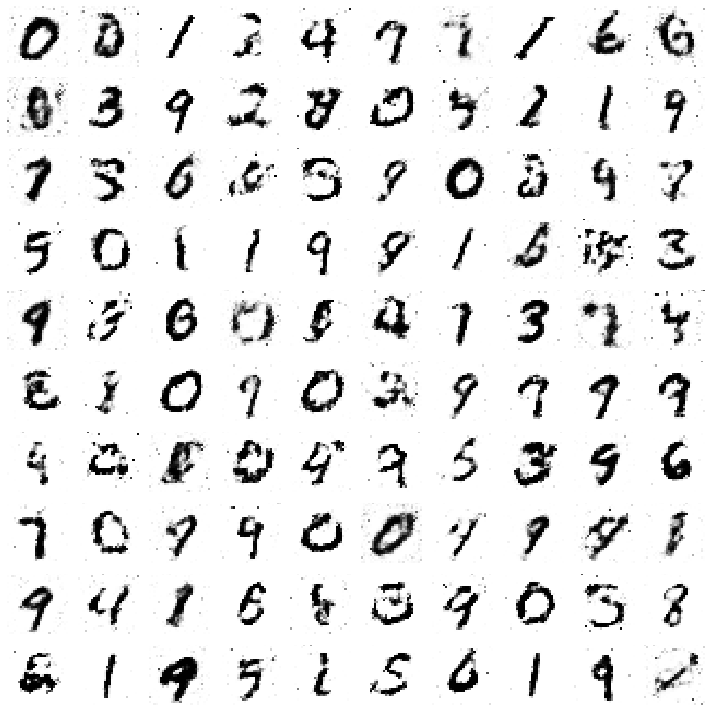

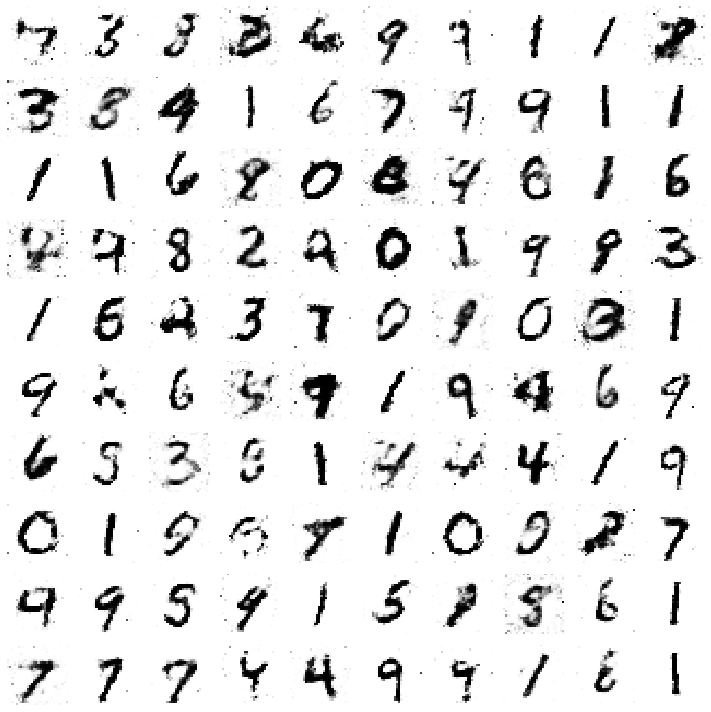

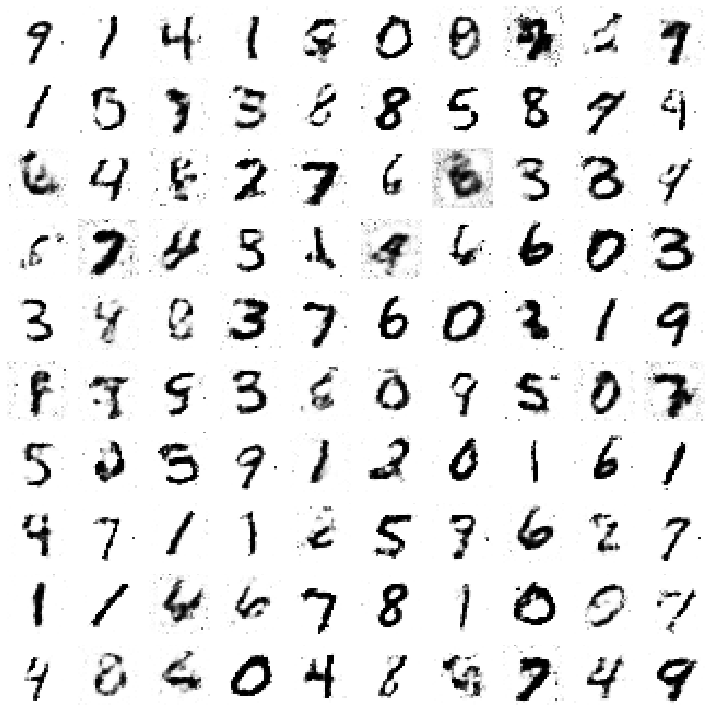

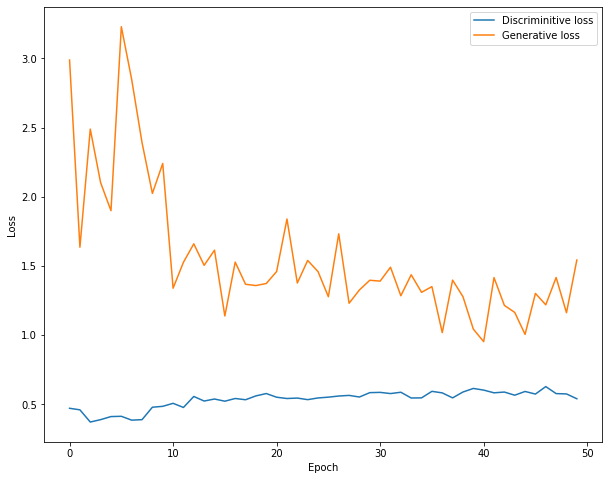

In [0]:
# Running the model
train(50, 128) 

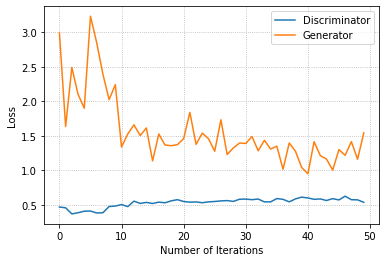

In [0]:
# ploting Loss

def plotLoss(train, test):
    iterations = list(range(len(train)))
    plt.plot(iterations, train, label="Discriminator")
    plt.plot(iterations, test, label="Generator")       

    plt.xlabel("Number of Iterations")
    plt.ylabel("Loss")
    plt.grid(True, linestyle='dotted')
    plt.legend() #loc="upper left"

    plt.show()

plotLoss(dLosses, gLosses)    

In [0]:
def plotGeneratedImages(epoch, examples=40, dim=(10, 4), figsize=(10, 4)):
    noise = np.random.normal(0, 1, size=[examples, randomDim])
    generatedImages = generator.predict(noise)
    generatedImages = generatedImages.reshape(examples, 28, 28)

    plt.figure()
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generatedImages[i], interpolation='nearest', cmap=plt.cm.gray)
        plt.axis('off')

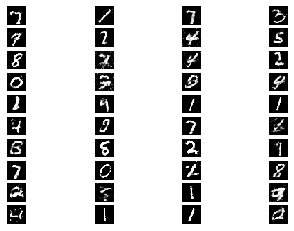

In [0]:
# Generate images 

plotGeneratedImages(50)

In [0]:
# Network Layer 1024


# defining discriminator model
discriminator = Sequential()
discriminator.add(Dense(1024, input_dim=784))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(512))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=adam)

# defining generator model

generator = Sequential()
generator.add(Dense(256, input_dim=randomDim))
generator.add(LeakyReLU(0.2))
generator.add(Dense(512))
generator.add(LeakyReLU(0.2))
generator.add(Dense(1024))
generator.add(LeakyReLU(0.2))
generator.add(Dense(784, activation='tanh'))
generator.compile(loss='binary_crossentropy', optimizer=adam)


# Combined network
discriminator.trainable = False
ganInput = Input(shape=(randomDim,))
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(inputs=ganInput, outputs=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=adam)


dLosses = []
gLosses = []

# Plot the loss from each batch

def plotLoss(epoch):
    plt.figure(figsize=(10, 8))
    plt.plot(dLosses, label='Discriminitive loss')
    plt.plot(gLosses, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('/content/Images_NL/gan_loss_epoch_NL1024_%d.png' % epoch)

# Create a wall of generated MNIST images
def plotGeneratedImages(epoch, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, randomDim])
    generatedImages = generator.predict(noise)
    generatedImages = generatedImages.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generatedImages[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('/content/Images_NL/gan_generated_image_epoch_NL1024_%d.png' % epoch)

# training a model

def train(epochs=1, batchSize=128):
    batchCount = X_train.shape[0] / batchSize
    print('Epochs:', epochs)
    print('Batch size:', batchSize)
    print('Batches per epoch:', batchCount)
    print('randomDim: ', randomDim)

    for e in range(1, epochs+1):
        print('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in tqdm(range(int(batchCount))):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            imageBatch = X_train[np.random.randint(0, X_train.shape[0], size=batchSize)]

            # Generate fake MNIST images
            generatedImages = generator.predict(noise)
            # print np.shape(imageBatch), np.shape(generatedImages)
            X = np.concatenate([imageBatch, generatedImages])

            # Labels for generated and real data
            yDis = np.zeros(2*batchSize)
            # One-sided label smoothing
            yDis[:batchSize] = 0.9

            # Train discriminator
            discriminator.trainable = True
            dloss = discriminator.train_on_batch(X, yDis)
            
            # Train generator
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            yGen = np.ones(batchSize)
            discriminator.trainable = False
            gloss = gan.train_on_batch(noise, yGen)
            

        # Store loss of most recent batch from this epoch
        dLosses.append(dloss)
        gLosses.append(gloss)
        if e == 1 or e % 10 == 0:
            plotGeneratedImages(e)

    # Plot losses from every epoch
    plotLoss(e)



  0%|          | 0/468 [00:00<?, ?it/s]

Epochs: 50
Batch size: 128
Batches per epoch: 468.75
randomDim:  10
--------------- Epoch 1 ---------------


  1%|▏         | 6/468 [00:00<00:07, 59.13it/s]

--------------- Epoch 2 ---------------


  1%|▏         | 7/468 [00:00<00:06, 67.40it/s]

--------------- Epoch 3 ---------------


  1%|▏         | 7/468 [00:00<00:07, 63.16it/s]

--------------- Epoch 4 ---------------


  1%|▏         | 7/468 [00:00<00:07, 61.84it/s]

--------------- Epoch 5 ---------------


  1%|▏         | 7/468 [00:00<00:06, 68.77it/s]

--------------- Epoch 6 ---------------


  2%|▏         | 8/468 [00:00<00:06, 72.42it/s]

--------------- Epoch 7 ---------------


  1%|▏         | 6/468 [00:00<00:07, 57.92it/s]

--------------- Epoch 8 ---------------


  1%|▏         | 7/468 [00:00<00:07, 64.33it/s]

--------------- Epoch 9 ---------------


  1%|▏         | 7/468 [00:00<00:06, 66.20it/s]

--------------- Epoch 10 ---------------


  1%|▏         | 6/468 [00:00<00:07, 59.04it/s]

--------------- Epoch 11 ---------------


  1%|▏         | 7/468 [00:00<00:07, 63.14it/s]

--------------- Epoch 12 ---------------


  1%|▏         | 7/468 [00:00<00:07, 64.81it/s]

--------------- Epoch 13 ---------------


  2%|▏         | 8/468 [00:00<00:06, 74.15it/s]

--------------- Epoch 14 ---------------


  1%|▏         | 7/468 [00:00<00:06, 69.40it/s]

--------------- Epoch 15 ---------------


  2%|▏         | 8/468 [00:00<00:06, 70.24it/s]

--------------- Epoch 16 ---------------


  2%|▏         | 8/468 [00:00<00:06, 71.08it/s]

--------------- Epoch 17 ---------------


  2%|▏         | 8/468 [00:00<00:06, 75.16it/s]

--------------- Epoch 18 ---------------


  1%|▏         | 7/468 [00:00<00:07, 63.22it/s]

--------------- Epoch 19 ---------------


  1%|▏         | 7/468 [00:00<00:06, 69.28it/s]

--------------- Epoch 20 ---------------


  1%|▏         | 7/468 [00:00<00:07, 63.89it/s]

--------------- Epoch 21 ---------------


  1%|▏         | 7/468 [00:00<00:06, 67.05it/s]

--------------- Epoch 22 ---------------


  2%|▏         | 8/468 [00:00<00:06, 76.05it/s]

--------------- Epoch 23 ---------------


  1%|▏         | 7/468 [00:00<00:06, 68.61it/s]

--------------- Epoch 24 ---------------


  2%|▏         | 8/468 [00:00<00:06, 72.94it/s]

--------------- Epoch 25 ---------------


  1%|▏         | 7/468 [00:00<00:07, 63.20it/s]

--------------- Epoch 26 ---------------


  1%|▏         | 6/468 [00:00<00:07, 58.04it/s]

--------------- Epoch 27 ---------------


  2%|▏         | 8/468 [00:00<00:06, 73.82it/s]

--------------- Epoch 28 ---------------


  1%|▏         | 7/468 [00:00<00:07, 63.54it/s]

--------------- Epoch 29 ---------------


  1%|▏         | 7/468 [00:00<00:07, 62.22it/s]

--------------- Epoch 30 ---------------


  1%|▏         | 7/468 [00:00<00:06, 68.31it/s]

--------------- Epoch 31 ---------------


  2%|▏         | 8/468 [00:00<00:06, 75.43it/s]

--------------- Epoch 32 ---------------


  2%|▏         | 8/468 [00:00<00:06, 76.38it/s]

--------------- Epoch 33 ---------------


  1%|▏         | 7/468 [00:00<00:07, 61.40it/s]

--------------- Epoch 34 ---------------


  1%|▏         | 7/468 [00:00<00:07, 65.53it/s]

--------------- Epoch 35 ---------------


  1%|▏         | 7/468 [00:00<00:06, 67.96it/s]

--------------- Epoch 36 ---------------


  1%|▏         | 6/468 [00:00<00:08, 55.52it/s]

--------------- Epoch 37 ---------------


  2%|▏         | 8/468 [00:00<00:06, 73.41it/s]

--------------- Epoch 38 ---------------


  1%|▏         | 7/468 [00:00<00:06, 68.11it/s]

--------------- Epoch 39 ---------------


  2%|▏         | 8/468 [00:00<00:06, 73.91it/s]

--------------- Epoch 40 ---------------


  1%|▏         | 7/468 [00:00<00:07, 65.21it/s]

--------------- Epoch 41 ---------------


  1%|▏         | 7/468 [00:00<00:06, 69.80it/s]

--------------- Epoch 42 ---------------


  2%|▏         | 8/468 [00:00<00:06, 76.18it/s]

--------------- Epoch 43 ---------------


  2%|▏         | 8/468 [00:00<00:06, 71.07it/s]

--------------- Epoch 44 ---------------


  1%|▏         | 7/468 [00:00<00:07, 65.76it/s]

--------------- Epoch 45 ---------------


  2%|▏         | 8/468 [00:00<00:06, 75.75it/s]

--------------- Epoch 46 ---------------


  1%|▏         | 7/468 [00:00<00:07, 63.52it/s]

--------------- Epoch 47 ---------------


  2%|▏         | 8/468 [00:00<00:06, 71.54it/s]

--------------- Epoch 48 ---------------


  1%|▏         | 7/468 [00:00<00:07, 61.90it/s]

--------------- Epoch 49 ---------------


  1%|▏         | 7/468 [00:00<00:07, 63.29it/s]

--------------- Epoch 50 ---------------


100%|██████████| 468/468 [00:06<00:00, 70.18it/s]


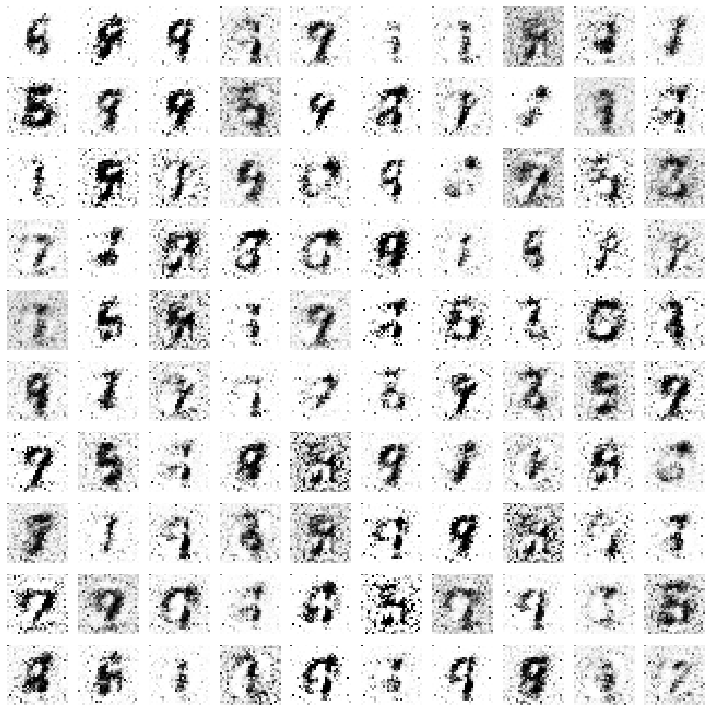

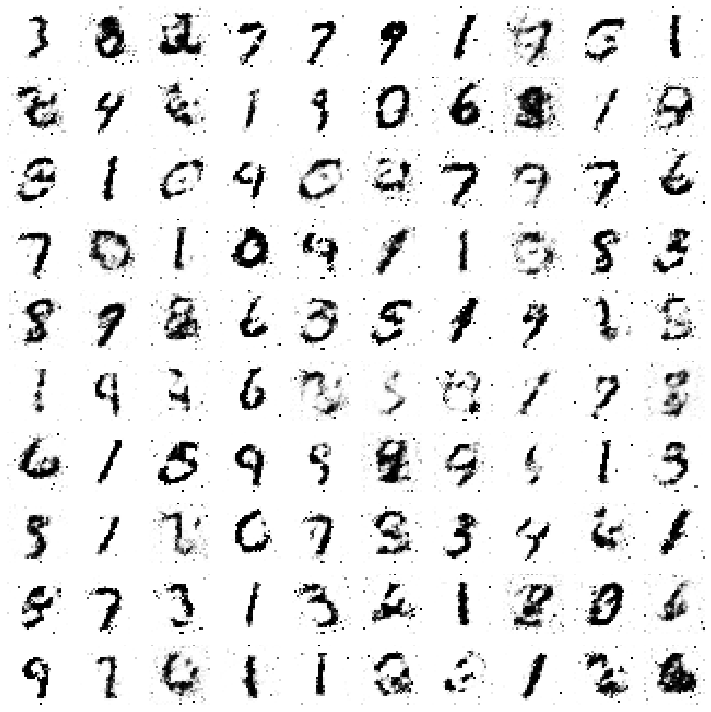

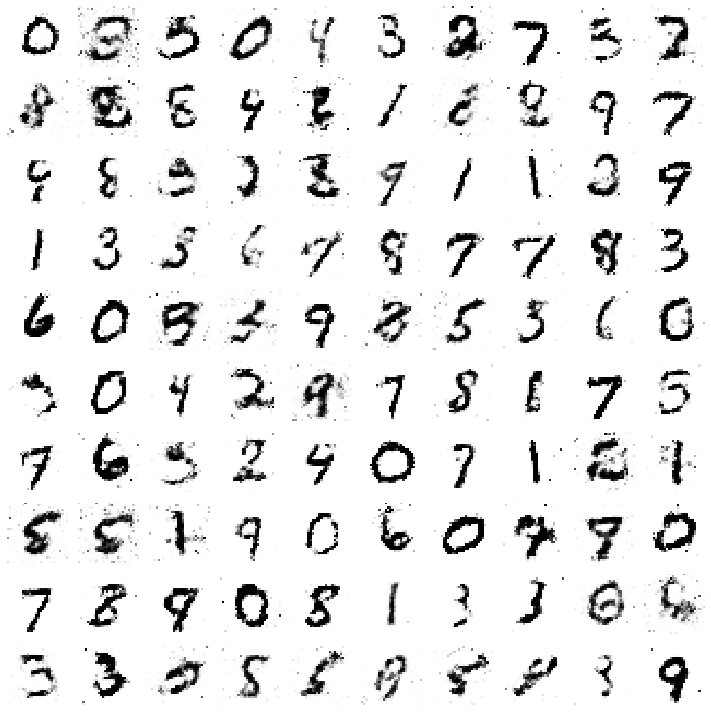

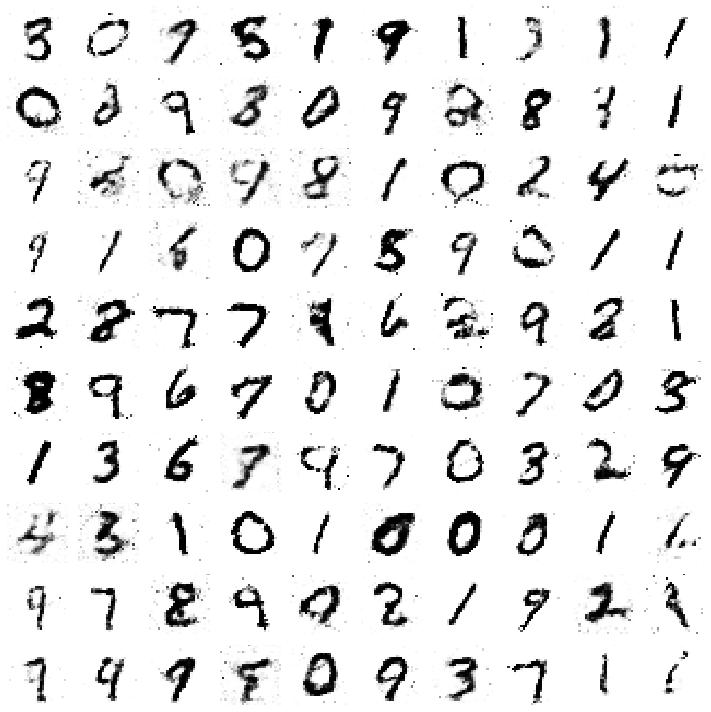

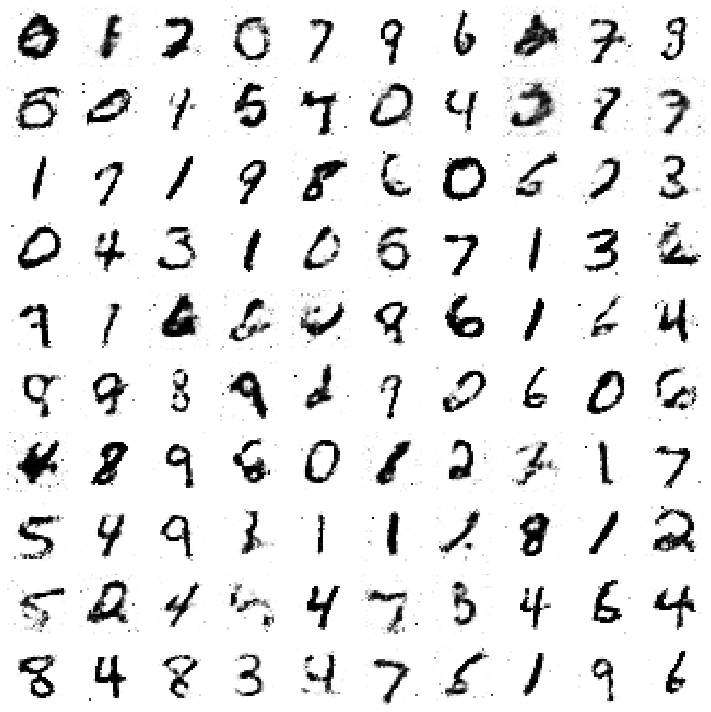

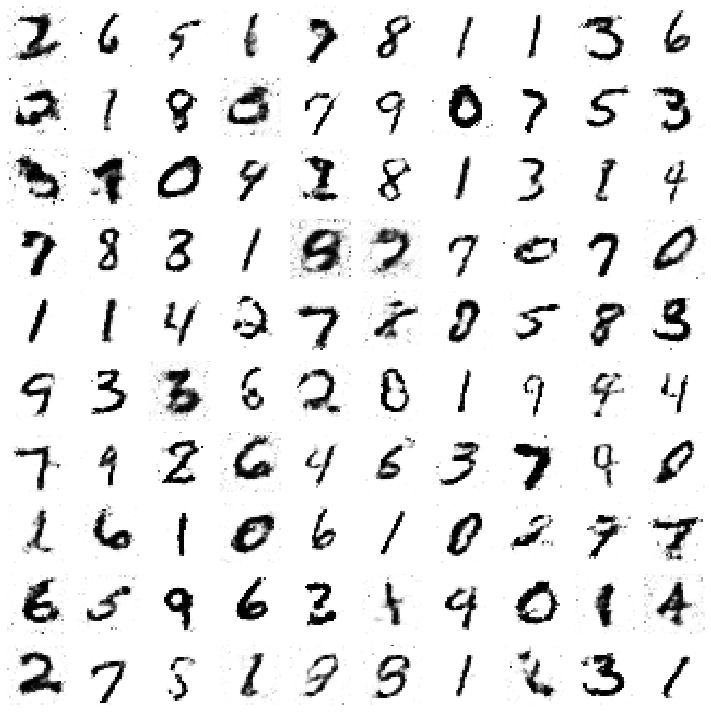

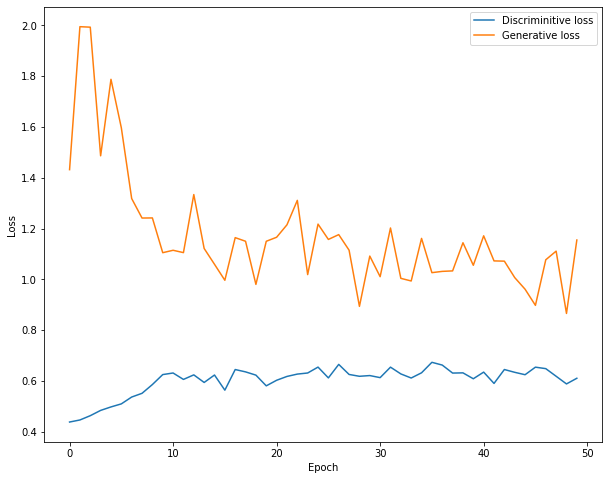

In [0]:
# Running the model
train(50, 128) 

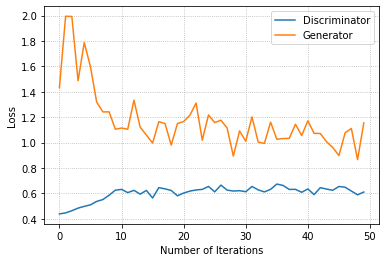

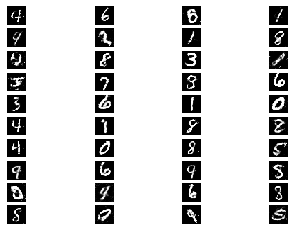

In [0]:
# ploting Loss

def plotLoss(train, test):
    iterations = list(range(len(train)))
    plt.plot(iterations, train, label="Discriminator")
    plt.plot(iterations, test, label="Generator")       

    plt.xlabel("Number of Iterations")
    plt.ylabel("Loss")
    plt.grid(True, linestyle='dotted')
    plt.legend() #loc="upper left"

    plt.show()

plotLoss(dLosses, gLosses)    

# Geneating numbers 

def plotGeneratedImages(epoch, examples=40, dim=(10, 4), figsize=(10, 4)):
    noise = np.random.normal(0, 1, size=[examples, randomDim])
    generatedImages = generator.predict(noise)
    generatedImages = generatedImages.reshape(examples, 28, 28)

    plt.figure()
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generatedImages[i], interpolation='nearest', cmap=plt.cm.gray)
        plt.axis('off')

# Generate images 

plotGeneratedImages(50)        

In [0]:
# NETWORK LAYER 64

# defining discriminator model
discriminator = Sequential()
discriminator.add(Dense(64, input_dim=784))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(64))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(128))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=adam)

# defining generator model

generator = Sequential()
generator.add(Dense(128, input_dim=randomDim))
generator.add(LeakyReLU(0.2))
generator.add(Dense(64))
generator.add(LeakyReLU(0.2))
generator.add(Dense(64))
generator.add(LeakyReLU(0.2))
generator.add(Dense(784, activation='tanh'))
generator.compile(loss='binary_crossentropy', optimizer=adam)


# Combined network
discriminator.trainable = False
ganInput = Input(shape=(randomDim,))
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(inputs=ganInput, outputs=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=adam)


dLosses = []
gLosses = []

# Plot the loss from each batch

def plotLoss(epoch):
    plt.figure(figsize=(10, 8))
    plt.plot(dLosses, label='Discriminitive loss')
    plt.plot(gLosses, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('/content/Images_NL/gan_loss_epoch_NL64_%d.png' % epoch)

# Create a wall of generated MNIST images
def plotGeneratedImages(epoch, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, randomDim])
    generatedImages = generator.predict(noise)
    generatedImages = generatedImages.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generatedImages[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('/content/Images_NL/gan_generated_image_epoch_NL64_%d.png' % epoch)

# training a model

def train(epochs=1, batchSize=128):
    batchCount = X_train.shape[0] / batchSize
    print('Epochs:', epochs)
    print('Batch size:', batchSize)
    print('Batches per epoch:', batchCount)
    print('randomDim: ', randomDim)

    for e in range(1, epochs+1):
        print('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in tqdm(range(int(batchCount))):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            imageBatch = X_train[np.random.randint(0, X_train.shape[0], size=batchSize)]

            # Generate fake MNIST images
            generatedImages = generator.predict(noise)
            # print np.shape(imageBatch), np.shape(generatedImages)
            X = np.concatenate([imageBatch, generatedImages])

            # Labels for generated and real data
            yDis = np.zeros(2*batchSize)
            # One-sided label smoothing
            yDis[:batchSize] = 0.9

            # Train discriminator
            discriminator.trainable = True
            dloss = discriminator.train_on_batch(X, yDis)
            

            # Train generator
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            yGen = np.ones(batchSize)
            discriminator.trainable = False
            gloss = gan.train_on_batch(noise, yGen)
            

        # Store loss of most recent batch from this epoch
        dLosses.append(dloss)
        gLosses.append(gloss)
        if e == 1 or e % 10 == 0:
            plotGeneratedImages(e)

    # Plot losses from every epoch
    plotLoss(e)

    

  0%|          | 0/468 [00:00<?, ?it/s]

Epochs: 50
Batch size: 128
Batches per epoch: 468.75
randomDim:  10
--------------- Epoch 1 ---------------


  1%|▏         | 7/468 [00:00<00:07, 65.01it/s]

--------------- Epoch 2 ---------------


  1%|▏         | 7/468 [00:00<00:06, 67.48it/s]

--------------- Epoch 3 ---------------


  1%|▏         | 7/468 [00:00<00:07, 60.81it/s]

--------------- Epoch 4 ---------------


  2%|▏         | 8/468 [00:00<00:06, 75.92it/s]

--------------- Epoch 5 ---------------


  2%|▏         | 8/468 [00:00<00:06, 73.31it/s]

--------------- Epoch 6 ---------------


  1%|▏         | 7/468 [00:00<00:07, 63.51it/s]

--------------- Epoch 7 ---------------


  2%|▏         | 8/468 [00:00<00:06, 72.99it/s]

--------------- Epoch 8 ---------------


  1%|▏         | 7/468 [00:00<00:07, 64.59it/s]

--------------- Epoch 9 ---------------


  1%|▏         | 7/468 [00:00<00:06, 66.07it/s]

--------------- Epoch 10 ---------------


  2%|▏         | 8/468 [00:00<00:06, 71.33it/s]

--------------- Epoch 11 ---------------


  1%|▏         | 7/468 [00:00<00:06, 67.44it/s]

--------------- Epoch 12 ---------------


  2%|▏         | 8/468 [00:00<00:06, 71.35it/s]

--------------- Epoch 13 ---------------


  2%|▏         | 8/468 [00:00<00:06, 74.30it/s]

--------------- Epoch 14 ---------------


  2%|▏         | 8/468 [00:00<00:06, 76.10it/s]

--------------- Epoch 15 ---------------


  2%|▏         | 8/468 [00:00<00:06, 71.80it/s]

--------------- Epoch 16 ---------------


  1%|▏         | 7/468 [00:00<00:07, 65.27it/s]

--------------- Epoch 17 ---------------


  1%|▏         | 7/468 [00:00<00:07, 65.13it/s]

--------------- Epoch 18 ---------------


  2%|▏         | 8/468 [00:00<00:06, 74.93it/s]

--------------- Epoch 19 ---------------


  1%|▏         | 7/468 [00:00<00:07, 62.31it/s]

--------------- Epoch 20 ---------------


  1%|▏         | 7/468 [00:00<00:06, 67.76it/s]

--------------- Epoch 21 ---------------


  1%|▏         | 7/468 [00:00<00:07, 64.74it/s]

--------------- Epoch 22 ---------------


  1%|▏         | 7/468 [00:00<00:06, 68.27it/s]

--------------- Epoch 23 ---------------


  2%|▏         | 8/468 [00:00<00:05, 76.91it/s]

--------------- Epoch 24 ---------------


  2%|▏         | 8/468 [00:00<00:06, 68.78it/s]

--------------- Epoch 25 ---------------


  2%|▏         | 8/468 [00:00<00:06, 75.36it/s]

--------------- Epoch 26 ---------------


  1%|▏         | 7/468 [00:00<00:07, 60.81it/s]

--------------- Epoch 27 ---------------


  1%|▏         | 7/468 [00:00<00:06, 65.93it/s]

--------------- Epoch 28 ---------------


  2%|▏         | 8/468 [00:00<00:06, 71.98it/s]

--------------- Epoch 29 ---------------


  1%|▏         | 7/468 [00:00<00:07, 65.70it/s]

--------------- Epoch 30 ---------------


  1%|▏         | 6/468 [00:00<00:07, 59.02it/s]

--------------- Epoch 31 ---------------


  1%|▏         | 7/468 [00:00<00:06, 66.29it/s]

--------------- Epoch 32 ---------------


  1%|▏         | 7/468 [00:00<00:06, 67.56it/s]

--------------- Epoch 33 ---------------


  1%|▏         | 7/468 [00:00<00:06, 69.68it/s]

--------------- Epoch 34 ---------------


  1%|▏         | 7/468 [00:00<00:06, 68.17it/s]

--------------- Epoch 35 ---------------


  2%|▏         | 8/468 [00:00<00:06, 70.83it/s]

--------------- Epoch 36 ---------------


  2%|▏         | 9/468 [00:00<00:05, 83.38it/s]

--------------- Epoch 37 ---------------


  1%|▏         | 7/468 [00:00<00:07, 63.56it/s]

--------------- Epoch 38 ---------------


  1%|▏         | 7/468 [00:00<00:07, 63.99it/s]

--------------- Epoch 39 ---------------


  1%|▏         | 6/468 [00:00<00:08, 56.25it/s]

--------------- Epoch 40 ---------------


  1%|▏         | 7/468 [00:00<00:07, 63.22it/s]

--------------- Epoch 41 ---------------


  2%|▏         | 8/468 [00:00<00:05, 79.51it/s]

--------------- Epoch 42 ---------------


  1%|▏         | 7/468 [00:00<00:07, 63.43it/s]

--------------- Epoch 43 ---------------


  1%|▏         | 7/468 [00:00<00:06, 65.93it/s]

--------------- Epoch 44 ---------------


  1%|▏         | 7/468 [00:00<00:07, 60.02it/s]

--------------- Epoch 45 ---------------


  1%|▏         | 7/468 [00:00<00:06, 65.86it/s]

--------------- Epoch 46 ---------------


  1%|▏         | 7/468 [00:00<00:06, 67.20it/s]

--------------- Epoch 47 ---------------


  2%|▏         | 8/468 [00:00<00:06, 71.82it/s]

--------------- Epoch 48 ---------------


  1%|▏         | 7/468 [00:00<00:07, 60.88it/s]

--------------- Epoch 49 ---------------


  2%|▏         | 8/468 [00:00<00:05, 78.05it/s]

--------------- Epoch 50 ---------------


100%|██████████| 468/468 [00:06<00:00, 70.27it/s]


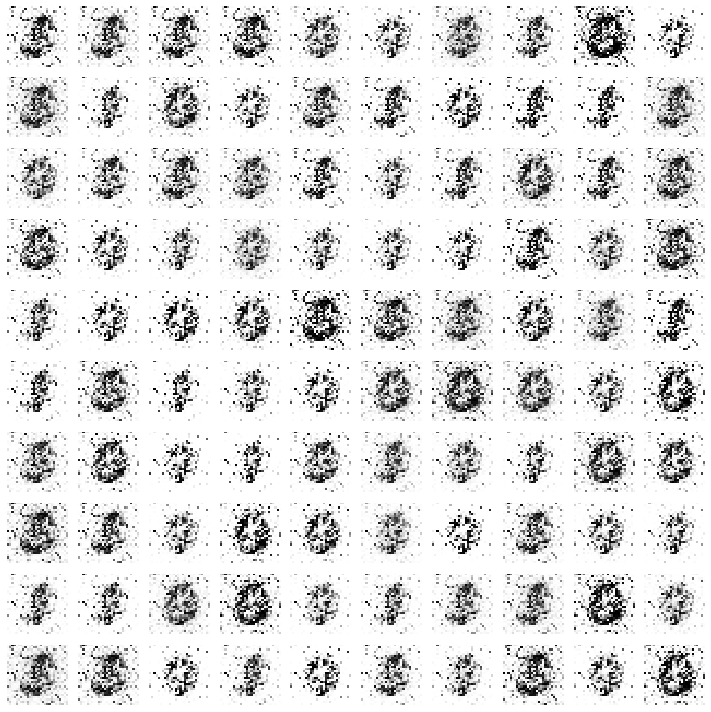

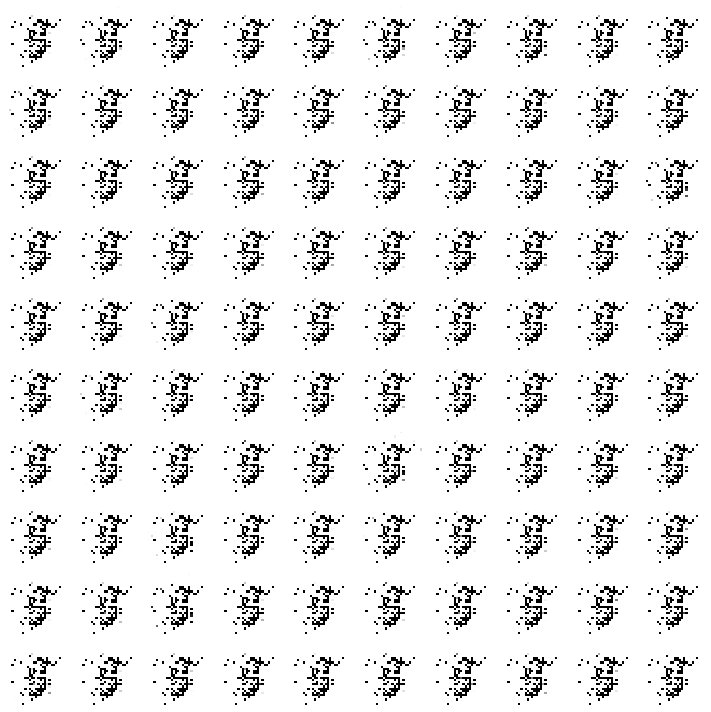

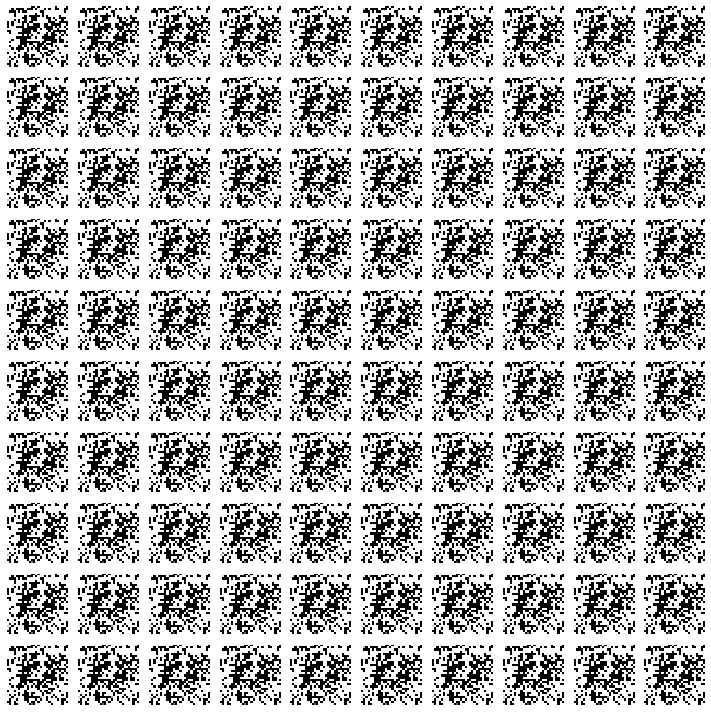

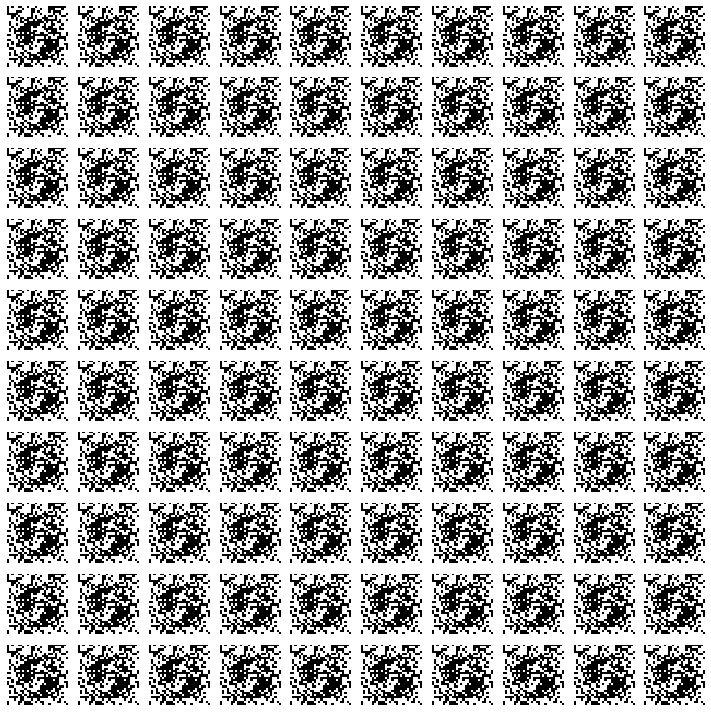

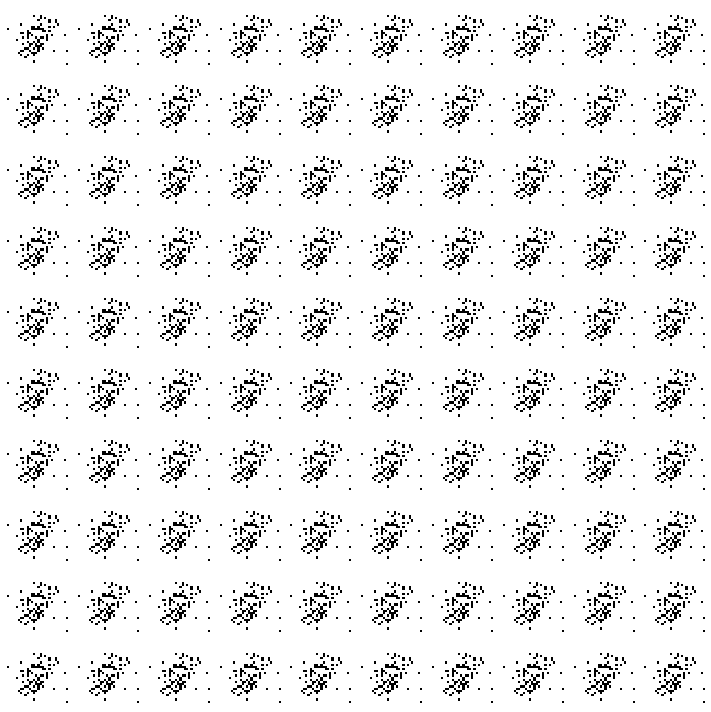

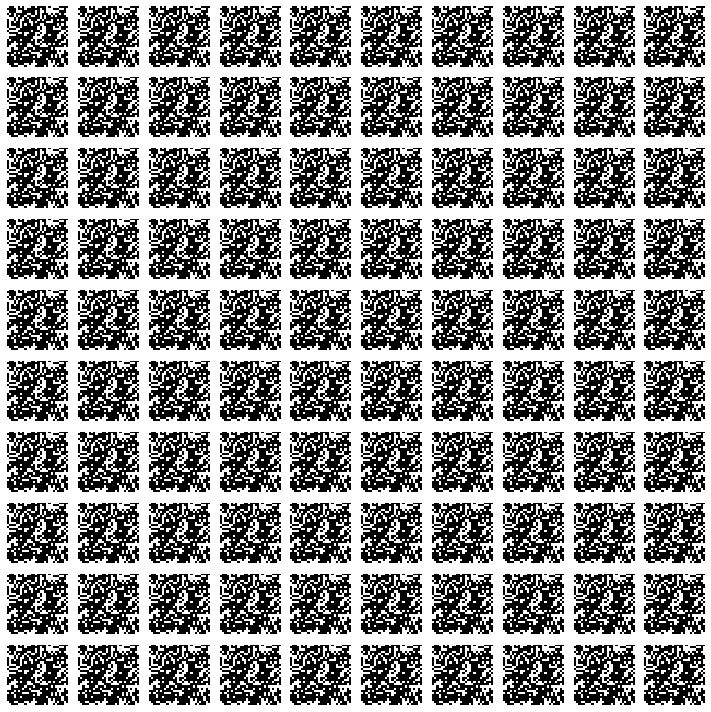

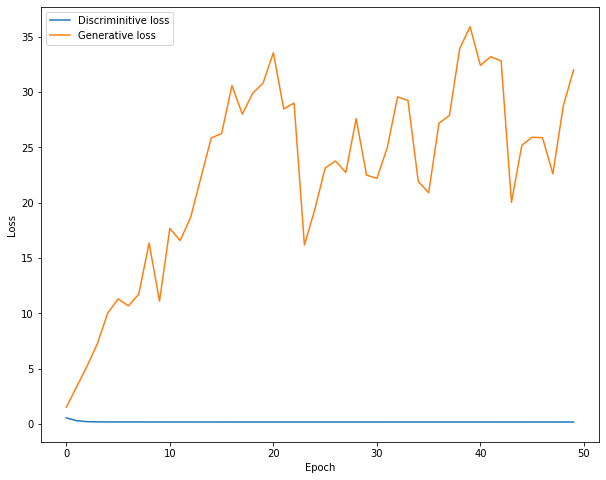

In [0]:
# Running the model
train(50, 128) 

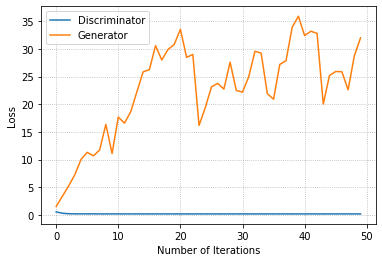

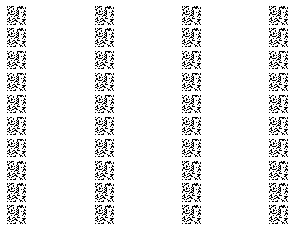

In [0]:
# ploting Loss

def plotLoss(train, test):
    iterations = list(range(len(train)))
    plt.plot(iterations, train, label="Discriminator")
    plt.plot(iterations, test, label="Generator")       

    plt.xlabel("Number of Iterations")
    plt.ylabel("Loss")
    plt.grid(True, linestyle='dotted')
    plt.legend() #loc="upper left"

    plt.show()

plotLoss(dLosses, gLosses)    

# Geneating numbers 

def plotGeneratedImages(epoch, examples=40, dim=(10, 4), figsize=(10, 4)):
    noise = np.random.normal(0, 1, size=[examples, randomDim])
    generatedImages = generator.predict(noise)
    generatedImages = generatedImages.reshape(examples, 28, 28)

    plt.figure()
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generatedImages[i], interpolation='nearest', cmap=plt.cm.gray)
        plt.axis('off')

# Generate images 

plotGeneratedImages(50)        

In [0]:
# network layer 128

# defining discriminator model
discriminator = Sequential()
discriminator.add(Dense(256, input_dim=784))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(128))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(128))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=adam)

# defining generator model

generator = Sequential()
generator.add(Dense(128, input_dim=randomDim))
generator.add(LeakyReLU(0.2))
generator.add(Dense(128))
generator.add(LeakyReLU(0.2))
generator.add(Dense(256))
generator.add(LeakyReLU(0.2))
generator.add(Dense(784, activation='tanh'))
generator.compile(loss='binary_crossentropy', optimizer=adam)


# Combined network
discriminator.trainable = False
ganInput = Input(shape=(randomDim,))
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(inputs=ganInput, outputs=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=adam)


dLosses = []
gLosses = []

# Plot the loss from each batch

def plotLoss(epoch):
    plt.figure(figsize=(10, 8))
    plt.plot(dLosses, label='Discriminitive loss')
    plt.plot(gLosses, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('/content/Images_NL/gan_loss_epoch_NL128_%d.png' % epoch)

# Create a wall of generated MNIST images
def plotGeneratedImages(epoch, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, randomDim])
    generatedImages = generator.predict(noise)
    generatedImages = generatedImages.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generatedImages[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('/content/Images_NL/gan_generated_image_epoch_NL128_%d.png' % epoch)

# training a model

def train(epochs=1, batchSize=128):
    batchCount = X_train.shape[0] / batchSize
    print('Epochs:', epochs)
    print('Batch size:', batchSize)
    print('Batches per epoch:', batchCount)
    print('randomDim: ', randomDim)

    for e in range(1, epochs+1):
        print('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in tqdm(range(int(batchCount))):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            imageBatch = X_train[np.random.randint(0, X_train.shape[0], size=batchSize)]

            # Generate fake MNIST images
            generatedImages = generator.predict(noise)
            # print np.shape(imageBatch), np.shape(generatedImages)
            X = np.concatenate([imageBatch, generatedImages])

            # Labels for generated and real data
            yDis = np.zeros(2*batchSize)
            # One-sided label smoothing
            yDis[:batchSize] = 0.9

            # Train discriminator
            discriminator.trainable = True
            dloss = discriminator.train_on_batch(X, yDis)
            

            # Train generator
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            yGen = np.ones(batchSize)
            discriminator.trainable = False
            gloss = gan.train_on_batch(noise, yGen)
           

        # Store loss of most recent batch from this epoch
        dLosses.append(dloss)
        gLosses.append(gloss)
        if e == 1 or e % 10 == 0:
            plotGeneratedImages(e)

    # Plot losses from every epoch
    plotLoss(e)



  0%|          | 0/468 [00:00<?, ?it/s]

Epochs: 50
Batch size: 128
Batches per epoch: 468.75
randomDim:  10
--------------- Epoch 1 ---------------


  1%|▏         | 7/468 [00:00<00:07, 64.94it/s]

--------------- Epoch 2 ---------------


  1%|▏         | 7/468 [00:00<00:06, 68.85it/s]

--------------- Epoch 3 ---------------


  2%|▏         | 8/468 [00:00<00:06, 70.67it/s]

--------------- Epoch 4 ---------------


  1%|▏         | 7/468 [00:00<00:07, 64.96it/s]

--------------- Epoch 5 ---------------


  2%|▏         | 8/468 [00:00<00:06, 71.56it/s]

--------------- Epoch 6 ---------------


  2%|▏         | 8/468 [00:00<00:06, 67.99it/s]

--------------- Epoch 7 ---------------


  1%|▏         | 7/468 [00:00<00:06, 66.27it/s]

--------------- Epoch 8 ---------------


  1%|▏         | 7/468 [00:00<00:07, 64.48it/s]

--------------- Epoch 9 ---------------


  1%|▏         | 6/468 [00:00<00:08, 57.05it/s]

--------------- Epoch 10 ---------------


  1%|▏         | 7/468 [00:00<00:06, 69.58it/s]

--------------- Epoch 11 ---------------


  1%|▏         | 6/468 [00:00<00:08, 54.89it/s]

--------------- Epoch 12 ---------------


  1%|▏         | 7/468 [00:00<00:06, 66.87it/s]

--------------- Epoch 13 ---------------


  2%|▏         | 8/468 [00:00<00:06, 66.77it/s]

--------------- Epoch 14 ---------------


  1%|▏         | 7/468 [00:00<00:06, 67.58it/s]

--------------- Epoch 15 ---------------


  2%|▏         | 8/468 [00:00<00:06, 70.88it/s]

--------------- Epoch 16 ---------------


  1%|▏         | 7/468 [00:00<00:07, 62.95it/s]

--------------- Epoch 17 ---------------


  1%|▏         | 7/468 [00:00<00:07, 61.25it/s]

--------------- Epoch 18 ---------------


  1%|▏         | 7/468 [00:00<00:06, 69.51it/s]

--------------- Epoch 19 ---------------


  1%|▏         | 7/468 [00:00<00:07, 65.08it/s]

--------------- Epoch 20 ---------------


  1%|▏         | 7/468 [00:00<00:07, 59.61it/s]

--------------- Epoch 21 ---------------


  1%|▏         | 7/468 [00:00<00:07, 64.74it/s]

--------------- Epoch 22 ---------------


  1%|▏         | 7/468 [00:00<00:06, 69.77it/s]

--------------- Epoch 23 ---------------


  1%|▏         | 7/468 [00:00<00:06, 69.13it/s]

--------------- Epoch 24 ---------------


  1%|▏         | 7/468 [00:00<00:06, 67.26it/s]

--------------- Epoch 25 ---------------


  2%|▏         | 8/468 [00:00<00:06, 69.45it/s]

--------------- Epoch 26 ---------------


  1%|▏         | 7/468 [00:00<00:07, 63.51it/s]

--------------- Epoch 27 ---------------


  1%|▏         | 7/468 [00:00<00:07, 61.64it/s]

--------------- Epoch 28 ---------------


  1%|▏         | 7/468 [00:00<00:06, 68.41it/s]

--------------- Epoch 29 ---------------


  1%|▏         | 6/468 [00:00<00:07, 59.40it/s]

--------------- Epoch 30 ---------------


  1%|▏         | 7/468 [00:00<00:07, 63.31it/s]

--------------- Epoch 31 ---------------


  1%|▏         | 7/468 [00:00<00:07, 62.73it/s]

--------------- Epoch 32 ---------------


  2%|▏         | 8/468 [00:00<00:06, 72.22it/s]

--------------- Epoch 33 ---------------


  1%|▏         | 6/468 [00:00<00:08, 53.27it/s]

--------------- Epoch 34 ---------------


  2%|▏         | 8/468 [00:00<00:06, 70.59it/s]

--------------- Epoch 35 ---------------


  2%|▏         | 8/468 [00:00<00:06, 70.88it/s]

--------------- Epoch 36 ---------------


  2%|▏         | 8/468 [00:00<00:06, 70.97it/s]

--------------- Epoch 37 ---------------


  2%|▏         | 8/468 [00:00<00:06, 72.37it/s]

--------------- Epoch 38 ---------------


  2%|▏         | 8/468 [00:00<00:06, 70.54it/s]

--------------- Epoch 39 ---------------


  1%|▏         | 7/468 [00:00<00:07, 63.96it/s]

--------------- Epoch 40 ---------------


  1%|▏         | 7/468 [00:00<00:07, 63.63it/s]

--------------- Epoch 41 ---------------


  1%|▏         | 7/468 [00:00<00:07, 65.42it/s]

--------------- Epoch 42 ---------------


  1%|▏         | 7/468 [00:00<00:07, 64.62it/s]

--------------- Epoch 43 ---------------


  1%|▏         | 7/468 [00:00<00:06, 67.62it/s]

--------------- Epoch 44 ---------------


  2%|▏         | 8/468 [00:00<00:06, 70.82it/s]

--------------- Epoch 45 ---------------


  2%|▏         | 8/468 [00:00<00:06, 72.21it/s]

--------------- Epoch 46 ---------------


  1%|▏         | 7/468 [00:00<00:07, 63.38it/s]

--------------- Epoch 47 ---------------


  1%|▏         | 7/468 [00:00<00:07, 65.08it/s]

--------------- Epoch 48 ---------------


  1%|▏         | 7/468 [00:00<00:07, 61.35it/s]

--------------- Epoch 49 ---------------


  2%|▏         | 8/468 [00:00<00:06, 71.89it/s]

--------------- Epoch 50 ---------------


100%|██████████| 468/468 [00:07<00:00, 68.86it/s]


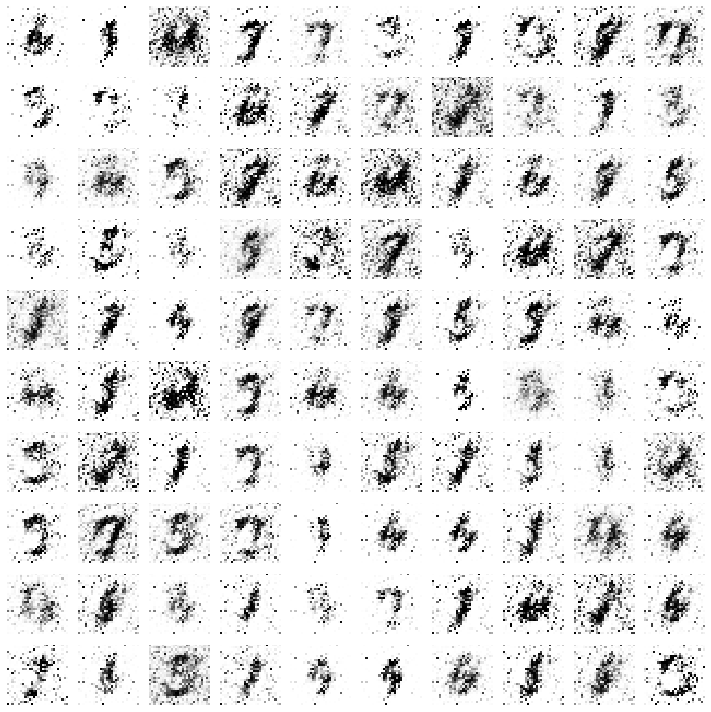

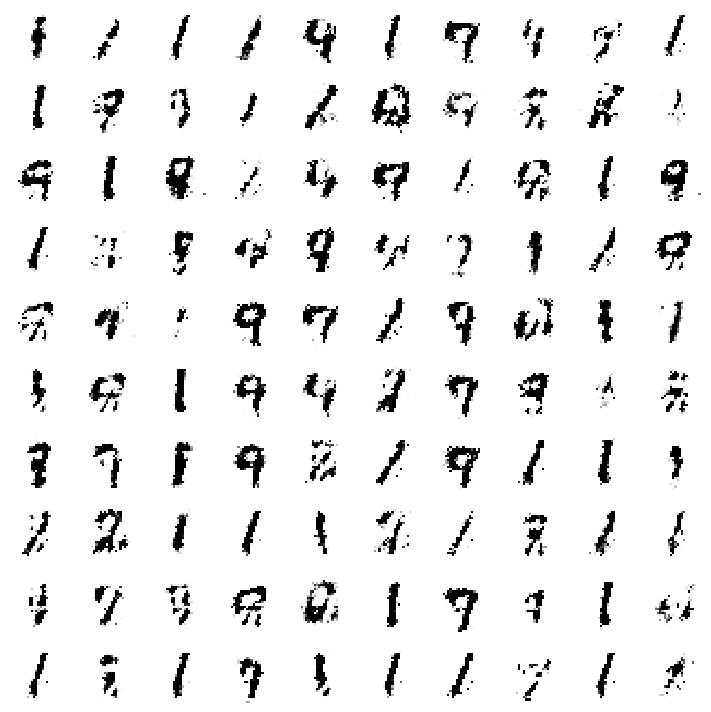

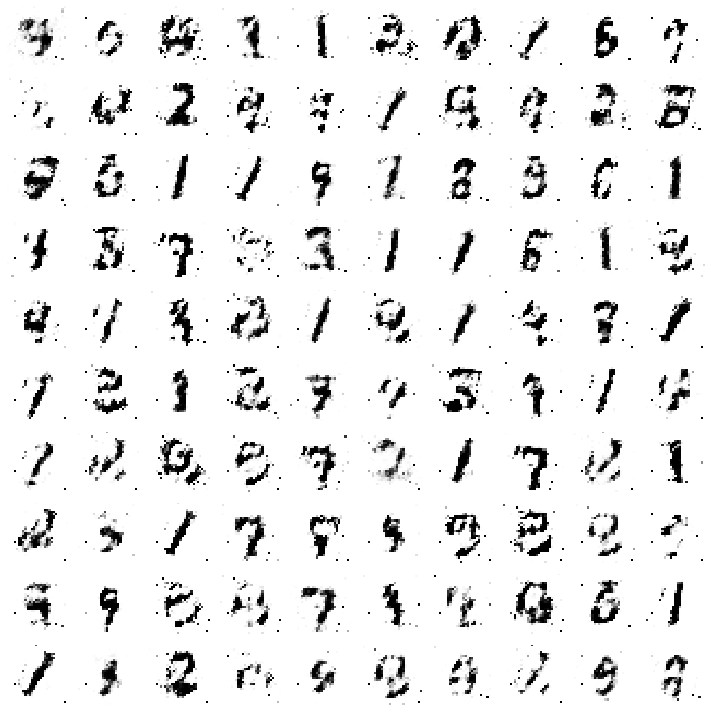

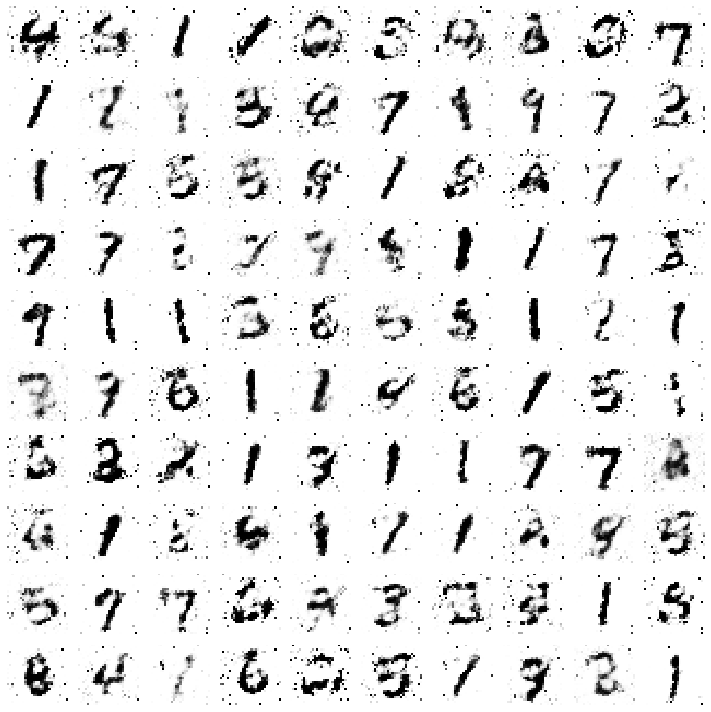

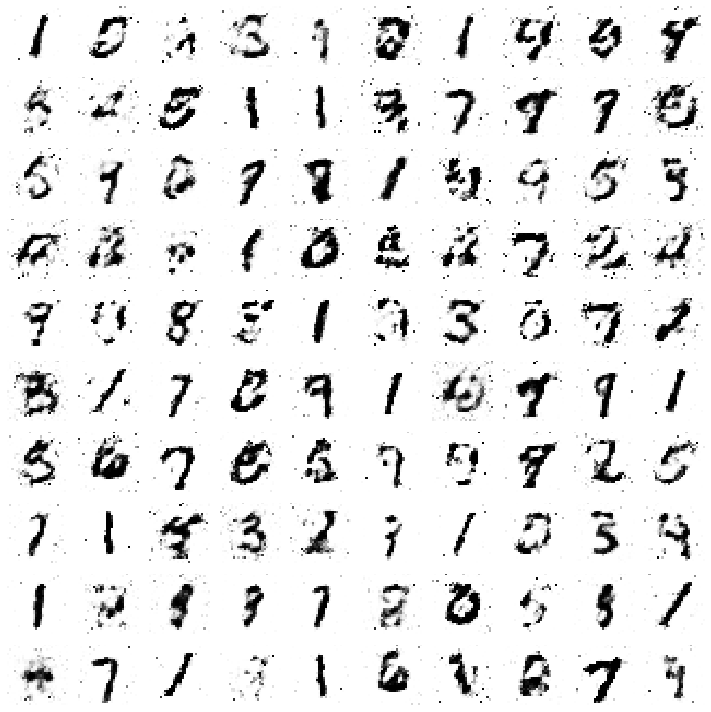

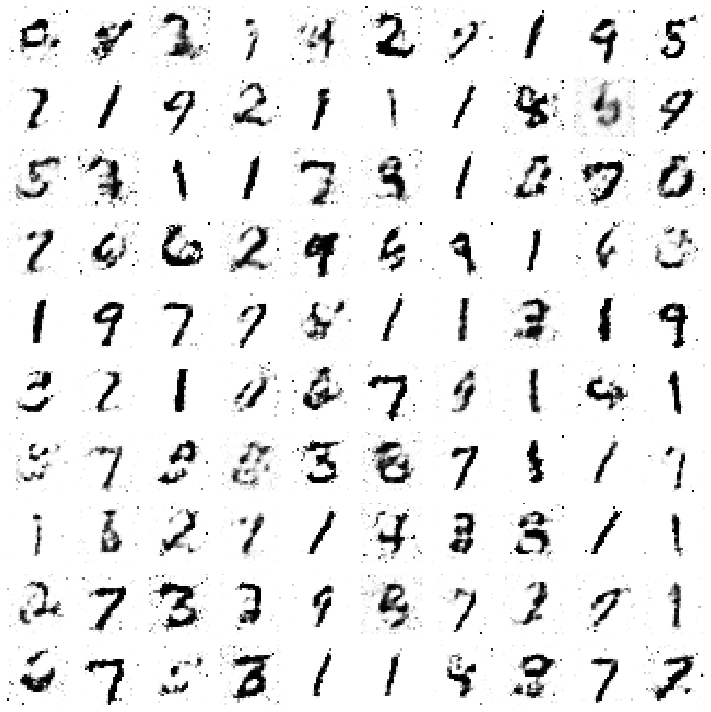

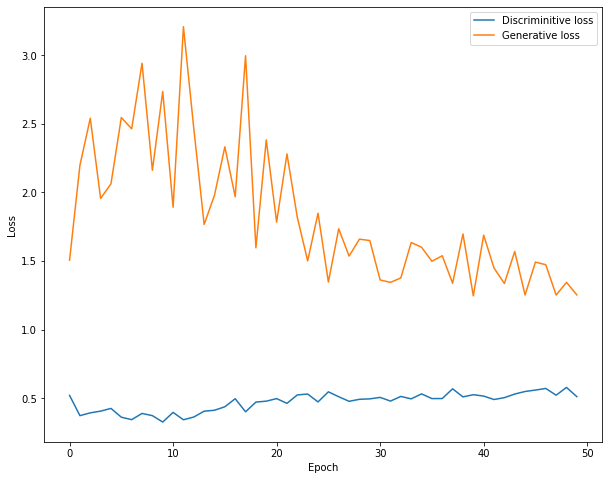

In [0]:
# Running the model
train(50, 128) 

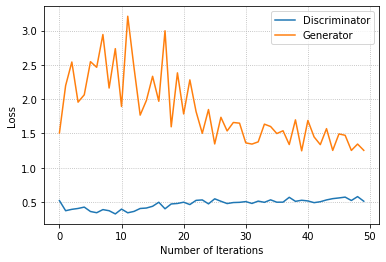

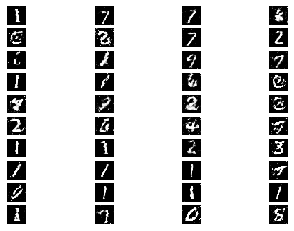

In [0]:
# ploting Loss

def plotLoss(train, test):
    iterations = list(range(len(train)))
    plt.plot(iterations, train, label="Discriminator")
    plt.plot(iterations, test, label="Generator")       

    plt.xlabel("Number of Iterations")
    plt.ylabel("Loss")
    plt.grid(True, linestyle='dotted')
    plt.legend() #loc="upper left"

    plt.show()

plotLoss(dLosses, gLosses)    

# Geneating numbers 

def plotGeneratedImages(epoch, examples=40, dim=(10, 4), figsize=(10, 4)):
    noise = np.random.normal(0, 1, size=[examples, randomDim])
    generatedImages = generator.predict(noise)
    generatedImages = generatedImages.reshape(examples, 28, 28)

    plt.figure()
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generatedImages[i], interpolation='nearest', cmap=plt.cm.gray)
        plt.axis('off')

# Generate images 

plotGeneratedImages(50)